==== Multi-Coin Database Preview ====
('bitcoin', 'BTC', 'Bitcoin', '2013-04-28', 1, 135.3, 135.98, 132.1, 134.21, 0.0, 1488566728.0, 0.5438, 3.88)
('bitcoin', 'BTC', 'Bitcoin', '2013-04-29', 1, 134.44, 147.49, 134.0, 144.54, 0.0, 1603768865.0, 0.7813, 13.49)
('bitcoin', 'BTC', 'Bitcoin', '2013-04-30', 1, 144.0, 146.93, 134.05, 139.0, 0.0, 1542813125.0, 0.3843, 12.88)
('bitcoin', 'BTC', 'Bitcoin', '2013-05-01', 1, 139.0, 139.89, 107.72, 116.99, 0.0, 1298954594.0, 0.2882, 32.17)
('bitcoin', 'BTC', 'Bitcoin', '2013-05-02', 1, 116.38, 125.6, 92.28, 105.21, 0.0, 1168517495.0, 0.3881, 33.32)
('bitcoin', 'BTC', 'Bitcoin', '2013-05-03', 1, 106.25, 108.13, 79.1, 97.75, 0.0, 1085995169.0, 0.6424, 29.03)
('bitcoin', 'BTC', 'Bitcoin', '2013-05-04', 1, 98.1, 115.0, 92.5, 112.5, 0.0, 1250316563.0, 0.8889, 22.5)
('bitcoin', 'BTC', 'Bitcoin', '2013-05-05', 1, 112.9, 118.8, 107.14, 115.91, 0.0, 1288693176.0, 0.7521, 11.66)
('bitcoin', 'BTC', 'Bitcoin', '2013-05-06', 1, 115.98, 124.66, 106.64, 112.3, 0

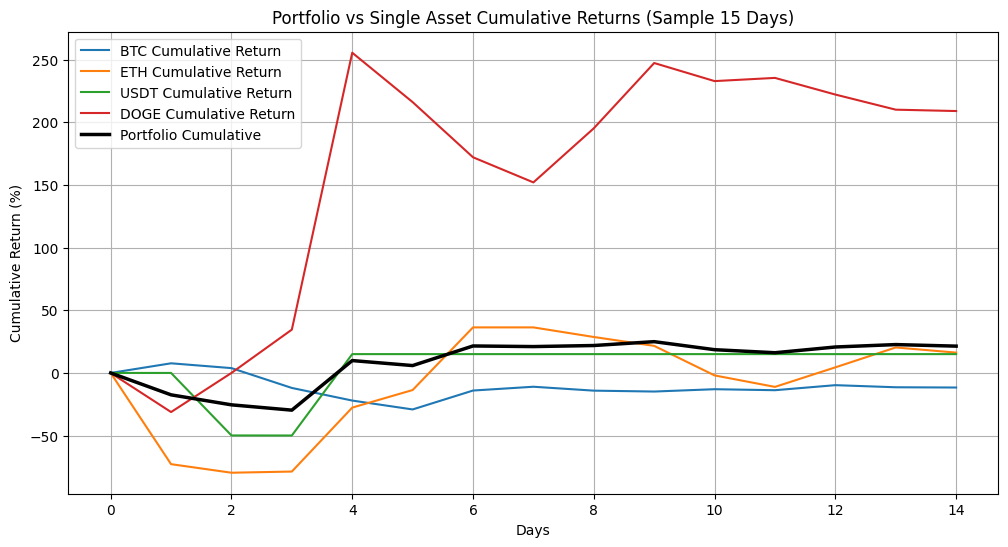

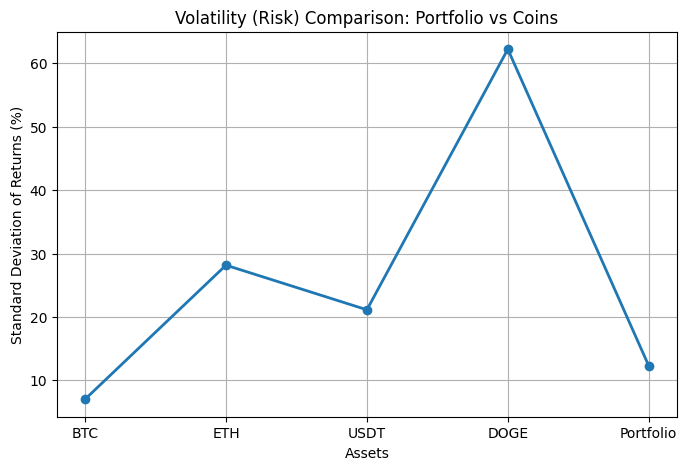


Risk Check Summary:

Volatility_annual: value = 0.5685056013096432, pass = False
Sharpe: value = 1.5448560587717877, pass = True
Max_Drawdown: value = -0.7609701496397246, pass = False
Sortino: value = 2.0190615894784, pass = True
Beta: value = 0.7542796578894212, pass = True
Max_Asset_Weight: value = 0.5, pass = False

RULE FAILURES !!!
- Volatility_annual: 0.5685056013096432
- Max_Drawdown: -0.7609701496397246
- Max_Asset_Weight: 0.5

Alert mail sent.

==== Predictions and Metrics ====



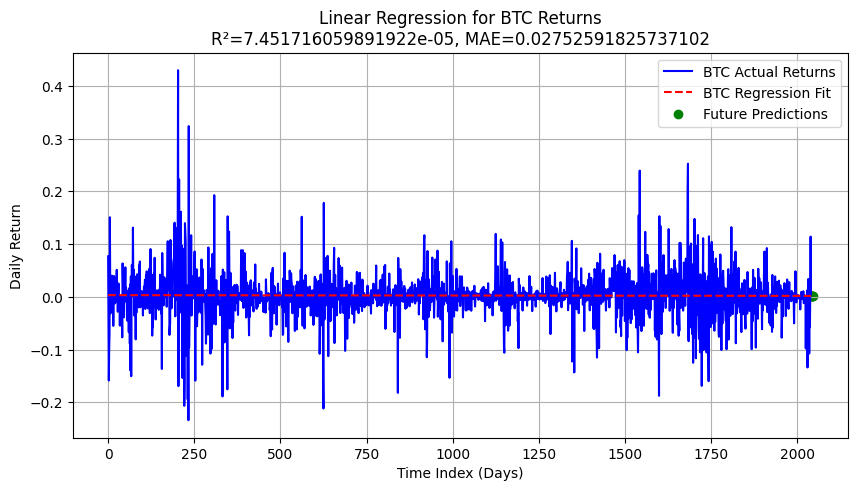

BTC next 5-day predicted returns: [0.00200166 0.00200101 0.00200037 0.00199972 0.00199908]


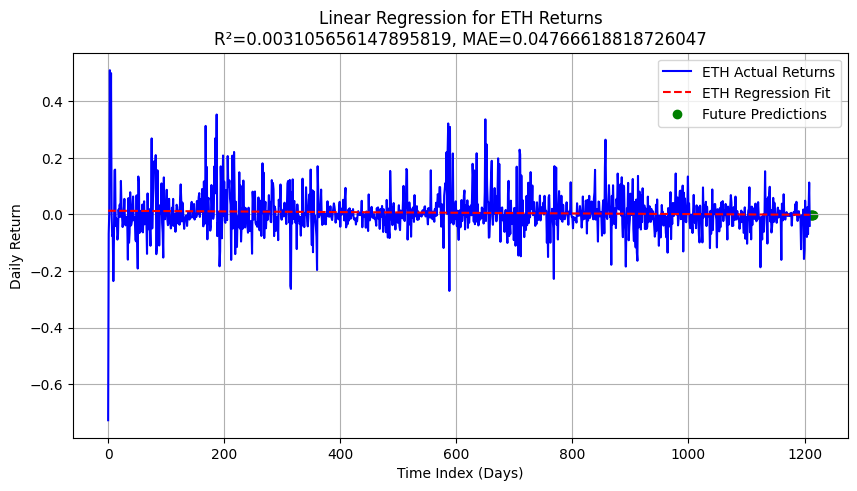

ETH next 5-day predicted returns: [-0.00116019 -0.00117199 -0.00118379 -0.00119559 -0.0012074 ]


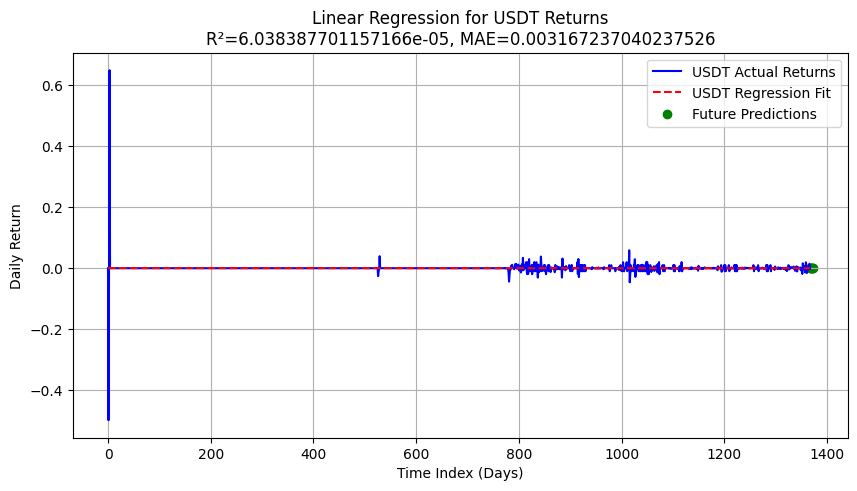

USDT next 5-day predicted returns: [-0.00018355 -0.00018401 -0.00018446 -0.00018491 -0.00018536]


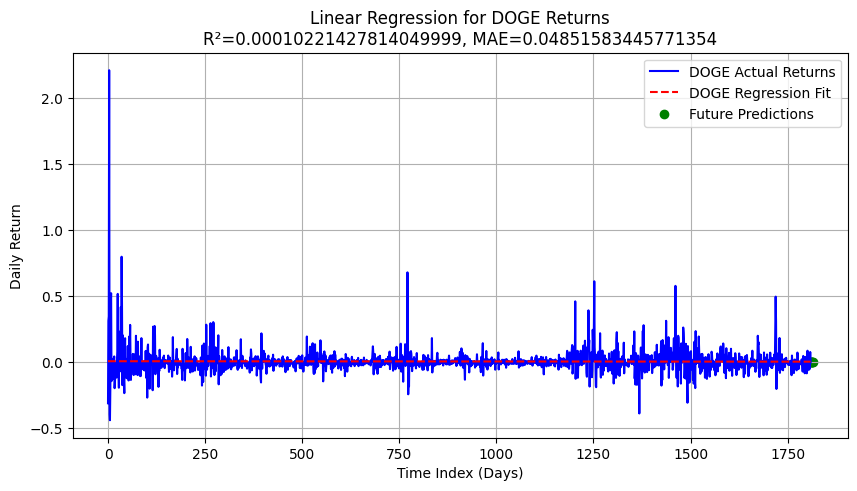

DOGE next 5-day predicted returns: [0.00305431 0.00305244 0.00305058 0.00304872 0.00304686]

=== Momentum Rule Portfolio ===

=== Daily Weights and Portfolio Returns (Momentum) ===
2015-08-08: BTC: 0.500, ETH: 0.500 | Portfolio Return: -0.397249
2015-08-09: BTC: 0.500, ETH: 0.500 | Portfolio Return: -0.026318
2015-08-10: BTC: 0.500, ETH: 0.500 | Portfolio Return: 0.003516
2015-08-11: BTC: 0.500, ETH: 0.500 | Portfolio Return: 0.266364
2015-08-12: BTC: 0.500, ETH: 0.500 | Portfolio Return: 0.062678
2015-08-13: BTC: 0.500, ETH: 0.500 | Portfolio Return: 0.245683
2015-08-14: BTC: 0.011, ETH: 0.989 | Portfolio Return: 0.000067
2015-08-15: BTC: 0.002, ETH: 0.998 | Portfolio Return: -0.076362
2015-08-16: BTC: 0.000, ETH: 1.000 | Portfolio Return: -0.071006
2015-08-17: BTC: 0.000, ETH: 1.000 | Portfolio Return: -0.235669
2015-08-18: BTC: 0.000, ETH: 1.000 | Portfolio Return: -0.091667
2015-08-19: BTC: 0.500, ETH: 0.500 | Portfolio Return: 0.114934
2015-08-20: BTC: 0.500, ETH: 0.500 | Portfoli

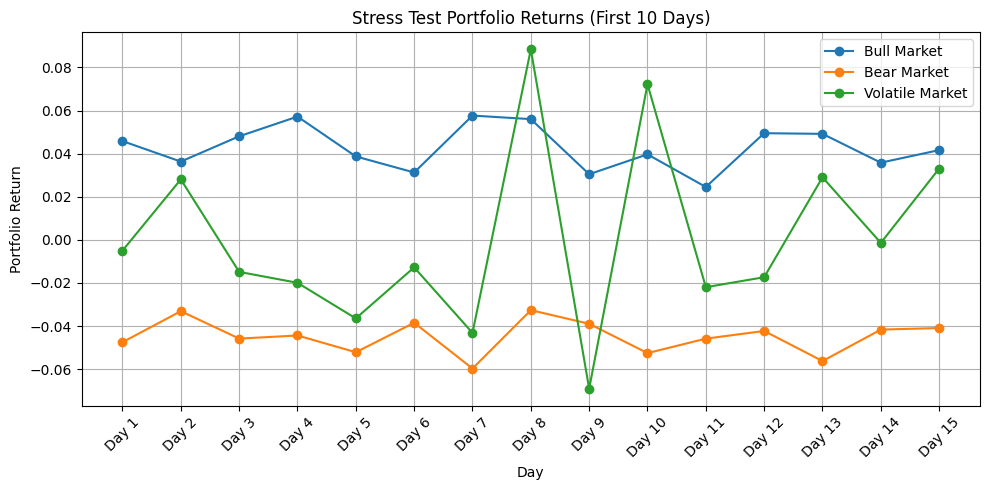

In [3]:
import os
import sqlite3
import smtplib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from pathlib import Path
from email.message import EmailMessage
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor, as_completed

# 1. Load and Prepare Dataset
file_path = "/content/drive/MyDrive/crypto-markets.csv"
df = pd.read_csv(file_path)

# Normalize coin names
df['symbol'] = df['symbol'].str.upper().str.strip()
coins = ['BTC', 'ETH', 'USDT', 'DOGE']
df = df[df['symbol'].isin(coins)]

# Sort dataset by date for time series consistency
df = df.sort_values(by=["symbol", "date"])

# 2. SQLite Database Handling
def store_in_db_multi(df, db_name="crypto_parallel.db", table="cryptodata", rows_per_coin=10):
    conn = sqlite3.connect("crypto_parallel.db")
    df.to_sql("cryptodata", conn, if_exists="replace", index=False)
    cursor = conn.cursor()

    preview = []
    for coin in df["symbol"].unique():
        cursor.execute(f"SELECT * FROM {table} WHERE symbol='{coin}' LIMIT {rows_per_coin}")
        coin_rows = cursor.fetchall()
        preview.extend(coin_rows)

    conn.close()
    return preview

# Save and preview
print("==== Multi-Coin Database Preview ====")
preview_data = store_in_db_multi(df, rows_per_coin=20)
for row in preview_data:
    print(row)

# 3. Utility Functions
def clean_numeric(series):
    """Ensure numeric conversion, strip unwanted chars if needed."""
    return pd.to_numeric(series.astype(str).str.replace(r'[^0-9.\-]', '', regex=True), errors='coerce')

# 4. Metrics Calculation
def percent_change(prices):
    changes = []
    for i in range(1, len(prices)):
        change = ((prices[i] - prices[i - 1]) / prices[i - 1]) * 100
        changes.append(round(change, 2))
    return changes

def moving_average(prices, window=3):
    sma = []
    for i in range(window, len(prices) + 1):
        avg = np.mean(prices[i - window:i])
        sma.append(round(avg, 2))
    return sma

def calculate_volatility(prices):
    changes = percent_change(prices)
    return round(np.std(changes), 2)

def trading_signal(prices):
    changes = percent_change(prices)
    signals = []
    for change in changes:
        if change > 2:
            signals.append("BUY")
        elif change < -2:
            signals.append("SELL")
        else:
            signals.append("HOLD")
    return signals

def portfolio_return(assetA, assetB, wA=0.6, wB=0.4):
    returns = []
    for a, b in zip(assetA, assetB):
        r = wA * a + wB * b
        returns.append(round(r, 2))
    return returns

# 5. Parallel Execution of Metrics
print("\n==== Calculate Metrics in Parallel ====")

btc_prices = df[df['symbol'] == "BTC"]['close'].tolist()
eth_prices = df[df['symbol'] == "ETH"]['close'].tolist() if "ETH" in df['symbol'].unique() else []

tasks = {
    "BTC Percentage Changes": lambda: percent_change(btc_prices)[:10],
    "BTC Simple Moving Average": lambda: moving_average(btc_prices, 5)[:10],
    "BTC Volatility": lambda: calculate_volatility(btc_prices),
    "BTC Trading Signals": lambda: trading_signal(btc_prices)[:10],
}

if eth_prices:
    tasks.update({
        "ETH Percentage Changes": lambda: percent_change(eth_prices)[:10],
        "ETH Simple Moving Average": lambda: moving_average(eth_prices, 5)[:10],
        "ETH Volatility": lambda: calculate_volatility(eth_prices),
        "ETH Trading Signals": lambda: trading_signal(eth_prices)[:10],
        "Portfolio Returns (BTC+ETH)": lambda: portfolio_return(btc_prices, eth_prices)[:15],
    })

results = {}
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(func): name for name, func in tasks.items()}
    for future in as_completed(futures):
        name = futures[future]
        try:
            results[name] = future.result()
        except Exception as e:
            results[name] = f"Error: {e}"

# 6. Final Results
for key, value in results.items():
    print(f"\n{key}: {value}")


df = pd.read_csv(file_path)
df['symbol'] = df['symbol'].str.upper().str.strip()
df = df[df['symbol'].isin(coins)]

def percent_change(prices):
    changes = []
    for i in range(1, len(prices)):
        change = ((prices[i] - prices[i - 1]) / prices[i - 1]) * 100
        changes.append(round(change, 4))
    return changes

def moving_average(prices, window=7):
    sma = []
    for i in range(window, len(prices) + 1):
        avg = np.mean(prices[i - window:i])
        sma.append(avg)
    return sma

def calculate_volatility(prices):
    changes = percent_change(prices)
    return round(np.std(changes), 4)

def trading_signal(prices):
    changes = percent_change(prices)
    signals = []
    for change in changes:
        if change > 2:
            signals.append("BUY")
        elif change < -2:
            signals.append("SELL")
        else:
            signals.append("HOLD")
    return signals

def compute_asset_metrics(symbol):
    temp = df[df['symbol'] == symbol].sort_values('date')
    close = temp['close'].tolist()
    pct_changes = percent_change(close)
    volatility = calculate_volatility(close)
    ma7 = moving_average(close, 7)[-1] if len(close) >= 7 else np.mean(close)
    signal = trading_signal(close)[-1] if pct_changes else "HOLD"
    return {
        "Currency": symbol,
        "Avg_Percent_Change": np.mean(pct_changes) if pct_changes else 0,
        "Volatility": volatility,
        "Moving_Avg": ma7,
        "Signal": signal
    }

assets_data = [compute_asset_metrics(c) for c in coins]
assets_df = pd.DataFrame(assets_data)
print("\n==== Asset Metrics ====")
print(assets_df)

# Allocation rules ( equal weights , market-capitalization , performance-based )
equal_weights = {c: 1/len(coins) for c in coins}
m_weights = {"BTC": 0.50, "ETH": 0.25, "USDT": 0.15, "DOGE": 0.10}
perf = assets_df["Avg_Percent_Change"].replace(0, np.nan)
perf_weights = (perf / perf.sum()).fillna(0)
perf_weights = dict(zip(assets_df["Currency"], perf_weights))
rules = {"Equal_Weight": equal_weights, "Market_Capitalization": m_weights, "Performance_Based": perf_weights}

def compute_portfolio(weights, assets_df):
    total_weight = sum(weights.values())
    if not np.isclose(total_weight, 1.0):
        raise ValueError(f"Weights do not sum to 1. Current sum = {total_weight}")
    df_copy = assets_df.copy()
    df_copy["Weight"] = df_copy["Currency"].map(weights)
    port_return = (df_copy["Avg_Percent_Change"] * df_copy["Weight"]).sum()
    port_risk = (df_copy["Volatility"] * df_copy["Weight"]).sum()
    return {"Portfolio_Return": port_return, "Portfolio_Risk": port_risk}

def run_rule(name, weights):
    result = compute_portfolio(weights, assets_df)
    result["Rule"] = name
    return result

results = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(run_rule, k, v) for k, v in rules.items()]
    for f in as_completed(futures):
        results.append(f.result())

portfolio_df = pd.DataFrame(results)
print("\n==== Multiple Rule Results ====")
print(portfolio_df)

# Export daily returns and risks
sample_df = df.sort_values('date').groupby('symbol').head(15)
returns_dict = {}
for c in coins:
    temp = sample_df[sample_df['symbol'] == c].sort_values('date')
    prices = temp['close'].values
    daily_returns = pd.Series(prices).pct_change().fillna(0) * 100
    returns_dict[c] = daily_returns.values
returns_df = pd.DataFrame(returns_dict)
weights = m_weights
w_array = np.array([weights[c] for c in coins])
returns_df["Portfolio"] = returns_df.dot(w_array)
plt.figure(figsize=(12, 6))
for c in coins:
    plt.plot(returns_df.index, returns_df[c].cumsum(), label=f"{c} Cumulative Return")
plt.plot(returns_df.index, returns_df["Portfolio"].cumsum(), linewidth=2.5, color="black", label="Portfolio Cumulative")
plt.title("Portfolio vs Single Asset Cumulative Returns (Sample 15 Days)")
plt.xlabel("Days")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.show()
risks = {c: np.std(returns_df[c]) for c in coins}
risks["Portfolio"] = np.std(returns_df["Portfolio"])
plt.figure(figsize=(8, 5))
plt.plot(list(risks.keys()), list(risks.values()), marker='o', linestyle='-', linewidth=2)
plt.title("Volatility (Risk) Comparison: Portfolio vs Coins")
plt.xlabel("Assets")
plt.ylabel("Standard Deviation of Returns (%)")
plt.grid(True)
plt.show()

# Configuration
DATA_PATH = "/content/drive/MyDrive/crypto-markets.csv"
DB_PATH = "risk_checks.db"
COINS = ["BTC", "ETH", "USDT", "DOGE"]
PORTFOLIO_WEIGHTS = {"BTC": 0.50, "ETH": 0.25, "USDT": 0.15, "DOGE": 0.10}
VOL_THRESHOLD = 0.05
SHARPE_THRESHOLD = 1.0
MAX_DRAWDOWN_THRESHOLD = -0.20
SORTINO_THRESHOLD = 1.0
BETA_THRESHOLD = 1.2
MAX_ASSET_WEIGHT = 0.40
MARKET_PROXY = "BTC"
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587
SMTP_USER = "janavarsh08@gmail.com"
SMTP_PASS = "eycyjcacxgosgrjm"
EMAIL_FROM = "janavarsh08@gmail.com"
EMAIL_TO = ["janavarsh08@gmail.com"]
EMAIL_SUBJECT = "ALERT: Risk rule(s) failed for portfolio"
TRADING_DAYS = 252
SQRT_TRADING = sqrt(TRADING_DAYS)

# Data Loading & Preparation
def load_and_prepare(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    df = pd.read_csv(path)
    df['symbol'] = df['symbol'].astype(str).str.upper().str.strip()
    df = df[df['symbol'].isin(COINS)].copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.sort_values(['symbol', 'date'])
    if 'close' not in df.columns:
        raise ValueError("CSV must contain a 'close' column.")
    return df

def compute_daily_returns(df):
    series = {}
    for coin in COINS:
        temp = df[df['symbol'] == coin].sort_values('date')
        if 'date' in temp.columns:
            s = pd.Series(temp['close'].values, index=temp['date']).astype(float)
        else:
            s = pd.Series(temp['close'].values)
        series[coin] = s.pct_change().rename(coin)
    returns_df = pd.concat(series, axis=1).dropna(how='all')
    return returns_df

def portfolio_returns(returns_df, weights):
    avail = [c for c in COINS if c in returns_df.columns]
    w = np.array([weights[c] for c in avail])
    port = returns_df[avail].dot(w)
    port.name = "PORTFOLIO"
    return port

# Metrics & Risk Rules
def annualized_volatility(series):
    return series.std(skipna=True) * SQRT_TRADING

def annualized_return(series):
    return series.mean(skipna=True) * TRADING_DAYS

def sharpe_ratio(series, rf=0.0):
    ann_ret = annualized_return(series)
    ann_vol = annualized_volatility(series)
    if ann_vol == 0 or np.isnan(ann_vol):
        return np.nan
    return (ann_ret - rf) / ann_vol

def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max) - 1.0
    return drawdown.min()

def sortino_ratio(series, rf=0.0):
    mean_ann = annualized_return(series)
    downside = series[series < 0]
    if len(downside) == 0:
        return np.nan
    dd_ann = downside.std(skipna=True) * SQRT_TRADING
    if dd_ann == 0 or np.isnan(dd_ann):
        return np.nan
    return (mean_ann - rf) / dd_ann

def beta_vs_market(port_series, market_series):
    df = pd.concat([port_series, market_series], axis=1).dropna()
    if df.shape[0] < 2:
        return np.nan
    cov = np.cov(df.iloc[:, 0], df.iloc[:, 1])[0, 1]
    var = np.var(df.iloc[:, 1])
    if var == 0:
        return np.nan
    return cov / var

def send_failure_email(failures, all_results):
    msg = EmailMessage()
    text_lines = ["Risk rule failures detected for portfolio:\n"]
    for k, v in failures.items():
        text_lines.append(f"- {k}: value = {v['value']}")
    text_lines.append("\nFull metrics:")
    for k, v in all_results.items():
        text_lines.append(f"- {k}: {v}")
    body = "\n".join(str(x) for x in text_lines)
    msg['Subject'] = EMAIL_SUBJECT
    msg['From'] = EMAIL_FROM
    msg['To'] = ", ".join(EMAIL_TO)
    msg.set_content(body)
    try:
        with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as smtp:
            smtp.starttls()
            smtp.login(SMTP_USER, SMTP_PASS)
            smtp.send_message(msg)
    except Exception as e:
        print("Failed to send email alert:", e)

def evaluate_rules(data_df, portfolio_weights=PORTFOLIO_WEIGHTS):
    returns_df = compute_daily_returns(data_df)
    available = [c for c in COINS if c in returns_df.columns]
    w = {c: portfolio_weights.get(c, 0.0) for c in available}
    total_w = sum(w.values())
    if total_w == 0:
        raise ValueError("No weights assigned for available coins.")
    w = {k: v / total_w for k, v in w.items()}
    port_series = portfolio_returns(returns_df, w)
    vol_ann = annualized_volatility(port_series)
    sr = sharpe_ratio(port_series, rf=0.0)
    cum_growth = (1.0 + port_series).cumprod()
    mdd = max_drawdown(cum_growth)
    sortino = sortino_ratio(port_series, rf=0.0)
    beta = beta_vs_market(port_series, returns_df[MARKET_PROXY]) if MARKET_PROXY in returns_df else np.nan
    max_weight = max(w.values())
    rules_results = {
        "Volatility_annual": {"value": float(vol_ann), "pass": bool(vol_ann <= VOL_THRESHOLD)},
        "Sharpe": {"value": float(sr) if not np.isnan(sr) else None, "pass": bool(sr >= SHARPE_THRESHOLD if not np.isnan(sr) else False)},
        "Max_Drawdown": {"value": float(mdd), "pass": bool(mdd >= MAX_DRAWDOWN_THRESHOLD)},
        "Sortino": {"value": float(sortino) if not np.isnan(sortino) else None, "pass": bool(sortino >= SORTINO_THRESHOLD if not np.isnan(sortino) else False)},
        "Beta": {"value": float(beta) if not np.isnan(beta) else None, "pass": bool(beta <= BETA_THRESHOLD if not np.isnan(beta) else False)},
        "Max_Asset_Weight": {"value": float(max_weight), "pass": bool(max_weight <= MAX_ASSET_WEIGHT)}
    }
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute("""CREATE TABLE IF NOT EXISTS risk_results (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        metric TEXT,
        value REAL,
        passed INTEGER,
        timestamp DATETIME DEFAULT CURRENT_TIMESTAMP)""")
    cur.execute("""CREATE TABLE IF NOT EXISTS rule_failures (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        metric TEXT,
        value REAL,
        threshold TEXT,
        timestamp DATETIME DEFAULT CURRENT_TIMESTAMP)""")
    conn.commit()
    for metric, res in rules_results.items():
        val = res["value"]
        passed = 1 if res["pass"] else 0
        cur.execute("INSERT INTO risk_results (metric, value, passed) VALUES (?,?,?)", (metric, val if val is not None else None, passed))
        if not res["pass"]:
            thr_text = ""
            if metric == "Volatility_annual":
                thr_text = f"<= {VOL_THRESHOLD:.2%}"
            elif metric == "Sharpe":
                thr_text = f">= {SHARPE_THRESHOLD}"
            elif metric == "Max_Drawdown":
                thr_text = f">= {MAX_DRAWDOWN_THRESHOLD:.2%}"
            elif metric == "Sortino":
                thr_text = f">= {SORTINO_THRESHOLD}"
            elif metric == "Beta":
                thr_text = f"<= {BETA_THRESHOLD}"
            elif metric == "Max_Asset_Weight":
                thr_text = f"<= {MAX_ASSET_WEIGHT:.2%}"
            cur.execute("INSERT INTO rule_failures (metric, value, threshold) VALUES (?,?,?)", (metric, val, thr_text))
    conn.commit()
    conn.close()
    failures = {k: v for k, v in rules_results.items() if not v['pass']}
    if failures:
        send_failure_email(failures, rules_results)
    return {"metrics": rules_results, "failures": failures, "portfolio_weights": w, "portfolio_series_head": port_series.dropna().head(10).to_dict()}

# Linear Regression Predictor
def predict_and_plot(series, label, horizon=5):
    values = series.dropna().values
    if len(values) < 10:
        return None
    X = np.arange(len(values)).reshape(-1, 1)
    y = values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    future_X = np.arange(len(values), len(values) + horizon).reshape(-1, 1)
    preds = model.predict(future_X)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    plt.figure(figsize=(10, 5))
    plt.plot(X, y, label=f"{label} Actual Returns", color="blue")
    plt.plot(X, y_pred, label=f"{label} Regression Fit", color="red", linestyle="--")
    plt.scatter(future_X, preds, color="green", label="Future Predictions")
    plt.title(f"Linear Regression for {label} Returns\nR²={r2}, MAE={mae}")
    plt.xlabel("Time Index (Days)")
    plt.ylabel("Daily Return")
    plt.legend()
    plt.grid(True)
    plt.show()
    return preds, r2, mae

# Run ( Main )
if __name__ == "__main__":
    df_all = load_and_prepare(DATA_PATH)
    results = evaluate_rules(df_all, portfolio_weights=PORTFOLIO_WEIGHTS)
    print("\nRisk Check Summary:\n")
    for metric, r in results["metrics"].items():
        print(f"{metric}: value = {r['value']}, pass = {r['pass']}")
    if results["failures"]:
        print("\nRULE FAILURES !!!")
        for k, v in results["failures"].items():
            print(f"- {k}: {v['value']}")
        print("\nAlert mail sent.")
    else:
        print("\nAll rules passed.")

    returns_df = compute_daily_returns(df_all)
    port_series = portfolio_returns(returns_df, PORTFOLIO_WEIGHTS)

    print("\n==== Predictions and Metrics ====\n")
    for coin in COINS:
        result = predict_and_plot(returns_df[coin], coin, horizon=5)
        if result:
            preds, r2, mae = result
            print(f"{coin} next 5-day predicted returns: {preds}")

# Configuration
DATA_PATH = "/content/drive/MyDrive/crypto-markets.csv"
COINS = ["BTC", "ETH"]
DB_PATH = "crypto_stress_test_momentum.db"

# 1. Load Data
def load_data(path):
    from pathlib import Path
    import pandas as pd
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    df = pd.read_csv(path)
    df['symbol'] = df['symbol'].str.upper().str.strip()
    df = df[df['symbol'].isin(COINS)]
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values(['symbol', 'date'])
    return df

# 2. Compute Daily Returns
def compute_daily_returns(df):
    import numpy as np
    import pandas as pd
    series = {}
    for coin in COINS:
        temp = df[df['symbol'] == coin].sort_values('date')
        prices = temp['close'].astype(float)
        returns = prices.pct_change().dropna()
        series[coin] = returns.values
    min_len = min(len(v) for v in series.values())
    returns_df = pd.DataFrame({c: series[c][-min_len:] for c in COINS}, index=df['date'].unique()[-min_len:])
    return returns_df

# 3. Momentum Rule ( Dynamic Weights )
def momentum_weights(returns_df, window=5):
    w = []
    for i in range(len(returns_df)):
        if i < window:
            w.append({c: 1/len(COINS) for c in COINS})
            continue
        momentum = (returns_df.iloc[i-window:i].mean()).clip(lower=0)
        if momentum.sum() == 0:
            weights = pd.Series(1/len(COINS), index=COINS)
        else:
            weights = momentum / momentum.sum()
        w.append(weights.to_dict())
    return w

# 4. Portfolio Returns
def portfolio_returns_daily(returns_df, daily_weights):
    import numpy as np
    p = []
    for i, w in enumerate(daily_weights):
        arr = np.array([w[c] for c in returns_df.columns])
        p_ret = returns_df.iloc[i].dot(arr)
        p.append(p_ret)
    return pd.Series(p, index=returns_df.index)

# 5. Stress Test Scenarios
def stress_scenarios(n_days):
    import numpy as np
    btc_vol = np.array([(-1)**i * np.random.uniform(0.02, 0.12) for i in range(n_days)])
    eth_vol = np.array([(-1)**(i+1) * np.random.uniform(0.02, 0.10) for i in range(n_days)])
    return {
        "Bull Market": pd.DataFrame({
            "BTC": np.random.uniform(0.03, 0.07, n_days),
            "ETH": np.random.uniform(0.02, 0.06, n_days)
        }),
        "Bear Market": pd.DataFrame({
            "BTC": np.random.uniform(-0.07, -0.03, n_days),
            "ETH": np.random.uniform(-0.06, -0.02, n_days)
        }),
        "Volatile Market": pd.DataFrame({
            "BTC": btc_vol,
            "ETH": eth_vol
        })
    }

# 6. Apply Stress Test
def apply_stress_test_portfolio(daily_weights):
    n_days = len(daily_weights)
    scenarios = stress_scenarios(n_days)
    results = {s: [] for s in scenarios}
    for i, w in enumerate(daily_weights):
        for name, df_s in scenarios.items():
            arr = np.array([w[c] for c in df_s.columns])
            port_ret = df_s.iloc[i].dot(arr)
            results[name].append(port_ret)
    return pd.DataFrame(results, index=[f"Day {i+1}" for i in range(n_days)])

# 7. Save to Database
def save_to_db(rule_name, dates, daily_weights, stress_df):
    import sqlite3
    conn = sqlite3.connect(DB_PATH)
    cur = conn.cursor()
    cur.execute(f"DROP TABLE IF EXISTS stress_results_{rule_name.lower()}")
    cur.execute(f"""
        CREATE TABLE IF NOT EXISTS stress_results_{rule_name.lower()} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            date TEXT,
            btc_weight REAL,
            eth_weight REAL,
            bull_return REAL,
            bear_return REAL,
            volatile_return REAL,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        )
    """)
    conn.commit()
    for i, date in enumerate(dates):
        w = daily_weights[i]
        cur.execute(f"""
            INSERT INTO stress_results_{rule_name.lower()}
            (date, btc_weight, eth_weight, bull_return, bear_return, volatile_return)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (
            date.date(),
            float(w.get('BTC', 0.0)),
            float(w.get('ETH', 0.0)),
            float(stress_df.loc[f"Day {i+1}", "Bull Market"]),
            float(stress_df.loc[f"Day {i+1}", "Bear Market"]),
            float(stress_df.loc[f"Day {i+1}", "Volatile Market"])
        ))
    conn.commit()
    conn.close()

# 8. Run ( Main )
if __name__ == "__main__":
    if os.path.exists(DB_PATH):
        os.remove(DB_PATH)
    df = load_data(DATA_PATH)
    ret = compute_daily_returns(df)

    print("\n=== Momentum Rule Portfolio ===")
    w_list = momentum_weights(ret, window=5)
    p_ret = portfolio_returns_daily(ret, w_list)

    print("\n=== Daily Weights and Portfolio Returns (Momentum) ===")
    for d, w, pr in zip(ret.index, w_list, p_ret):
        ws = ", ".join([f"{k}: {v:.3f}" for k, v in w.items()])
        print(f"{d.date()}: {ws} | Portfolio Return: {pr:.6f}")

    stress_df = apply_stress_test_portfolio(w_list)
    print("\n=== Portfolio Stress Test Results (Momentum) ===")
    print(stress_df.head(50))

    save_to_db("Momentum", ret.index, w_list, stress_df)
    print(f"\nResults saved to {DB_PATH}")

    # 9. Plotting
    stress_plot = stress_df.head(15)
    plt.figure(figsize=(10, 5))
    for col in stress_plot.columns:
        plt.plot(stress_plot.index, stress_plot[col], marker='o', label=col)
    plt.xticks(rotation=45)
    plt.xlabel("Day")
    plt.ylabel("Portfolio Return")
    plt.title("Stress Test Portfolio Returns (First 10 Days)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()